<a href="https://colab.research.google.com/github/Taweilo/theLook_ecommerce/blob/main/theLook_rfm_delivery_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# theLook ecommerce project

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install squarify
import squarify
import warnings


# 1. RFM analysis (2019~2024)

![RFM metrics](https://clevertap.com/wp-content/uploads/2018/03/Incontent_image.png)

In [46]:
# import data
url_rfm_2019_2024 ='https://raw.githubusercontent.com/Taweilo/theLook_ecommerce/main/Data/rfm_2019_2024_data.csv'
rfm_df = pd.read_csv(url_rfm_2019_2024)
rfm_df.head()

,user_id,recency,frequency,monetary
0,11291,384,7,426.850002
1,97434,73,9,497.770002
2,49853,245,7,418.520002
3,64662,224,6,139.330002
4,21679,433,7,324.959996


In [47]:
print(rfm_df.shape)
print(" ")
print(rfm_df.info())

(27519, 4)
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27519 entries, 0 to 27518
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    27519 non-null  int64  
 1   recency    27519 non-null  int64  
 2   frequency  27519 non-null  int64  
 3   monetary   27519 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 860.1 KB
None


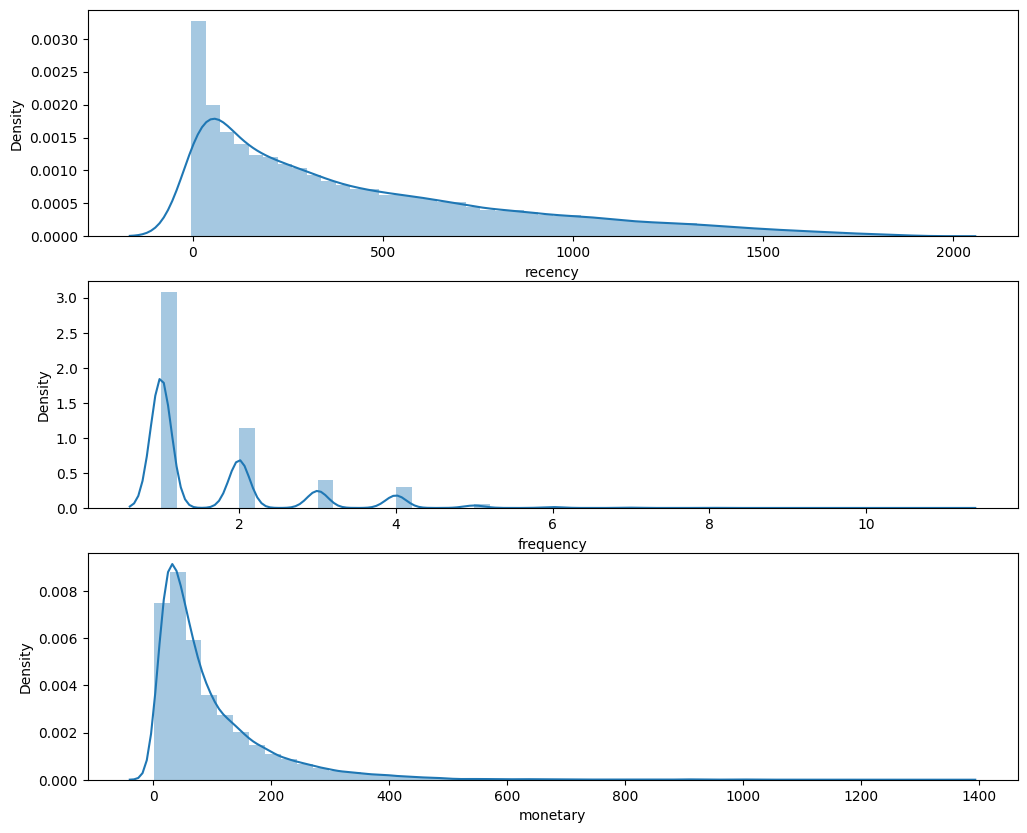

In [48]:
# Plotting RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm_df['recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm_df['frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm_df['monetary'])
# Show the plot
plt.show()

In [49]:
rfm_df["R"] = pd.qcut(rfm_df['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_df["F"] = pd.qcut(rfm_df["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm_df["M"] = pd.qcut(rfm_df["monetary"], 5, labels=[1, 2, 3, 4, 5])
rfm_df["rfm_df_Score"] = rfm_df["R"].astype(str) + rfm_df["F"].astype(str) + rfm_df["M"].astype(str)

| Segment                   | Description                                                                                      |
|---------------------------|--------------------------------------------------------------------------------------------------|
| Champions                 | Bought recently, buy often, and spend the most.                                                  |
| Loyal Customers           | Buy on a regular basis and are responsive to promotions.                                         |
| Potential Loyalist        | Recent customers with average frequency.                                                         |
| Recent Customers          | Bought most recently but not often.                                                               |
| Promising                 | Recent shoppers who haven't spent much.                                                           |
| Customers Needing Attention | Above-average recency, frequency, and monetary values. May not have bought very recently.      |
| About To Sleep            | Below-average recency and frequency. Will lose them if not reactivated.                           |
| At Risk                   | Purchased often but a long time ago. Need to bring them back!                                     |
| Can’t Lose Them           | Used to purchase frequently but haven’t returned for a long time.                                  |
| Hibernating               | Last purchase was a long time ago with a low number of orders. May be lost.                        |


In [50]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

![RFM treemap](https://guillaume-martin.github.io/images/rfm-segments.png)

In [51]:
rfm_df['segment'] = rfm_df['R'].astype(str) + rfm_df['F'].astype(str)
rfm_df['segment'] = rfm_df['segment'].replace(seg_map, regex=True)
rfm_df.head()

,user_id,recency,frequency,monetary,R,F,M,rfm_df_Score,segment
0,11291,384,7,426.850002,3,5,5,355,Loyal Customers
1,97434,73,9,497.770002,4,5,5,455,Loyal Customers
2,49853,245,7,418.520002,3,5,5,355,Loyal Customers
3,64662,224,6,139.330002,3,5,4,354,Loyal Customers
4,21679,433,7,324.959996,3,5,5,355,Loyal Customers


In [52]:
# Define the desired order of segments
segment_order = [
    'Champions', 'Loyal Customers', 'Potential Loyalists', 'New Customers',
    'Promising', 'Need Attention', 'About to Sleep', 'At Risk',
    'Can\'t Lose', 'Hibernating'
]

# Group by segment and calculate aggregates
rfm_grouped = rfm_df.groupby('segment').agg({'user_id': lambda x: ', '.join(x.astype(str)), 'recency': 'mean', 'frequency': 'mean', 'monetary': 'mean'})
rfm_grouped['user_count'] = rfm_df.groupby('segment')['user_id'].size()
rfm_grouped['percent'] = round((rfm_grouped['user_count']/rfm_grouped.user_count.sum())*100, 2)

# Reorder the segments based on segment_order
rfm_grouped = rfm_grouped.reindex(segment_order)

# Round 'recency', 'frequency', and 'monetary' columns to 2 digits
rfm_grouped[['recency', 'frequency', 'monetary']] = rfm_grouped[['recency', 'frequency', 'monetary']].round(2)

# Move the 'user_id' column to the end
rfm_grouped = rfm_grouped[['recency', 'frequency', 'monetary', 'user_count', 'percent', 'user_id']]

# Display the reordered and rounded DataFrame
rfm_grouped


,recency,frequency,monetary,user_count,percent,user_id
segment,,,,,,
Champions,27.49,2.65,167.26,2442,8.87,"65423, 84596, 94492, 81887, 4104, 37155, 92227..."
Loyal Customers,226.58,2.67,168.65,4511,16.39,"11291, 97434, 49853, 64662, 21679, 64470, 9018..."
Potential Loyalists,85.53,1.00,69.58,4158,15.11,"6898, 11238, 15115, 16364, 17300, 29771, 33477..."
New Customers,27.26,1.00,18.02,995,3.62,"9618, 13757, 5462, 66952, 88431, 11937, 77055,..."
Promising,139.06,1.00,17.95,1108,4.03,"94582, 63005, 93890, 38293, 24855, 37516, 1871..."
Need Attention,317.65,1.00,100.78,1073,3.90,"43253, 44169, 57752, 62966, 64260, 71253, 7196..."
About to Sleep,319.87,1.00,29.08,2234,8.12,"87818, 929, 41414, 58741, 60485, 53355, 59797,..."
At Risk,861.36,1.44,108.38,4486,16.30,"38752, 40419, 42677, 43492, 47749, 48820, 5579..."
Can't Lose,834.81,3.26,215.05,1895,6.89,"62645, 65964, 62998, 14745, 4966, 15906, 6327,..."


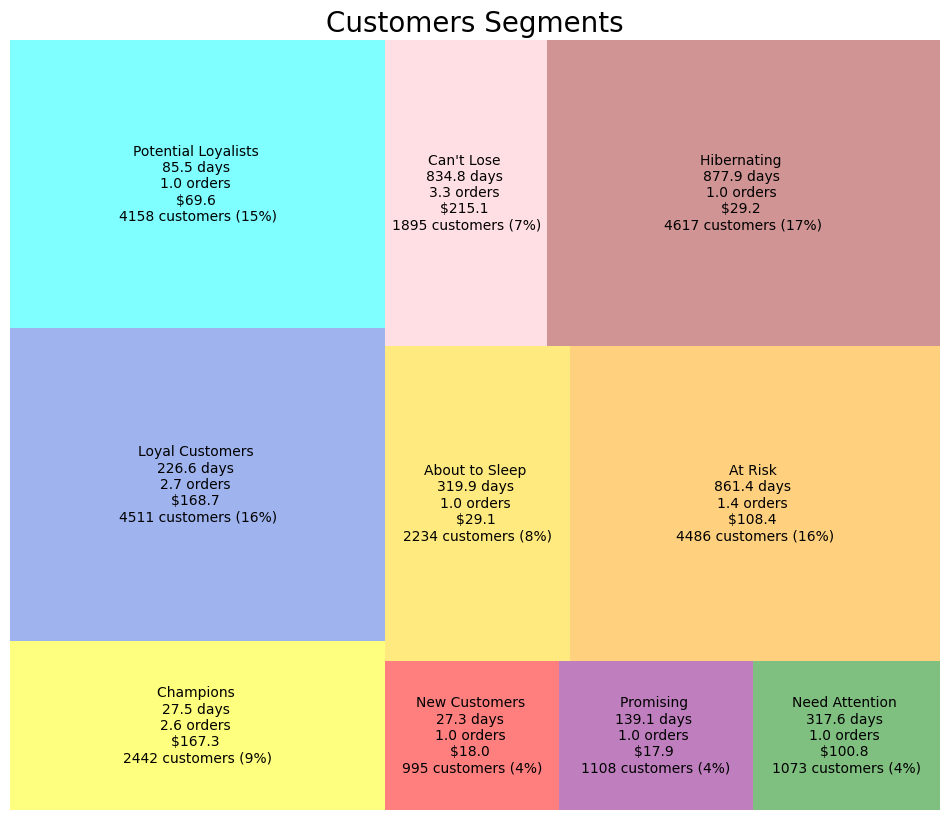

In [53]:
# Create color dic for the treemap
colors_dict = {
    'Champions': 'yellow',
    'Loyal Customers': 'royalblue',
    'Potential Loyalists': 'cyan',
    'New Customers': 'red',
    'Promising': 'purple',
    'Need Attention': 'green',
    'About to Sleep': 'gold',
    'At Risk': 'orange',
    "Can't Lose": 'pink',
    'Hibernating': 'brown'
}

# Create the plot and resize it
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot()

# Plot the treemap with labels and colors
squarify.plot(sizes=rfm_grouped['user_count'],
              #text_kwargs={'fontsize': 8, 'weight': 'bold', 'fontname': "sans serif"},
              color=[colors_dict[segment] for segment in rfm_grouped.index],
              label=['{} \n{:.1f} days \n{:.1f} orders \n${:.1f} \n{:.0f} customers ({:.0f}%)'.format(*row)
                     for row in rfm_grouped.itertuples()], alpha=0.5)

plt.title("Customers Segments", fontsize=20)
plt.axis('off')
plt.show()

![action](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*pGS1-NwGc_87IBtY)

https://guillaume-martin.github.io/rfm-segmentation-with-python.html

https://medium.com/@ogunbajoadeyinka/building-an-rfm-model-in-python-3481112a2816

https://melodyyip.github.io/RFM-UCI-onlineStore/

https://github.com/amr-khalil/Identify-customer-segmentation/blob/master/RFM%20Final.ipynb

https://github.com/klaudia-nazarko/rfm-analysis-python/blob/master/rfm_analysis_python.ipynb

https://medium.com/@ugursavci/customer-segmentation-using-rfm-analysis-in-python-218a3255f714 <br>
https://clevertap.com/blog/rfm-analysis/?source=post_page-----a33fa287c0e--------------------------------

# 2. Delivery analysis (2023 reevaluation)

In [54]:
# importing the libraries
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import warnings
from sklearn.cluster import KMeans
!pip install pyclustering
from pyclustering.cluster.kmedians import kmedians
from math import radians, sin, cos, sqrt, atan2

In [55]:
# import data
url_domestic_2023_delivery ='https://raw.githubusercontent.com/Taweilo/theLook_ecommerce/main/Data/us_delivery_2023_data.csv'
domestic_delivery_df = pd.read_csv(url_domestic_2023_delivery)
domestic_delivery_df.head()

,item_id,customer_postal_code,country,state,city,customer_longitude,customer_latitude,lead_time,name,dc_longitude,dc_latitude,delivered_at,shipped_at,created_at
0,32591,53716,United States,Wisconsin,Madison,-89.331811,43.066362,121.0,Mobile AL,-88.0431,30.6944,2023-05-07 08:24:00.000000 UTC,2023-05-04 01:28:00.000000 UTC,2023-05-02 07:09:51.000000 UTC
1,42105,92008,United States,California,Carlsbad,-117.318668,33.144374,41.0,Mobile AL,-88.0431,30.6944,2023-07-12 19:09:00.000000 UTC,2023-07-11 18:19:00.000000 UTC,2023-07-11 01:54:11.000000 UTC
2,180392,64804,United States,Missouri,Joplin,-94.510106,37.019306,95.0,Mobile AL,-88.0431,30.6944,2023-12-06 16:52:00.000000 UTC,2023-12-03 01:39:00.000000 UTC,2023-12-02 17:42:18.000000 UTC
3,94138,37604,United States,Tennessee,Johnson City,-82.382191,36.295325,77.0,Mobile AL,-88.0431,30.6944,2023-11-23 19:33:00.000000 UTC,2023-11-21 22:13:00.000000 UTC,2023-11-20 14:03:10.000000 UTC
4,145578,20723,United States,Maryland,North Laurel,-76.865842,39.136438,82.0,Mobile AL,-88.0431,30.6944,2023-03-02 11:06:00.000000 UTC,2023-03-01 05:02:00.000000 UTC,2023-02-27 00:38:50.000000 UTC


In [56]:
domestic_df= domestic_delivery_df[['customer_longitude','customer_latitude','dc_longitude','dc_latitude']]
domestic_df.head()

,customer_longitude,customer_latitude,dc_longitude,dc_latitude
0,-89.331811,43.066362,-88.0431,30.6944
1,-117.318668,33.144374,-88.0431,30.6944
2,-94.510106,37.019306,-88.0431,30.6944
3,-82.382191,36.295325,-88.0431,30.6944
4,-76.865842,39.136438,-88.0431,30.6944


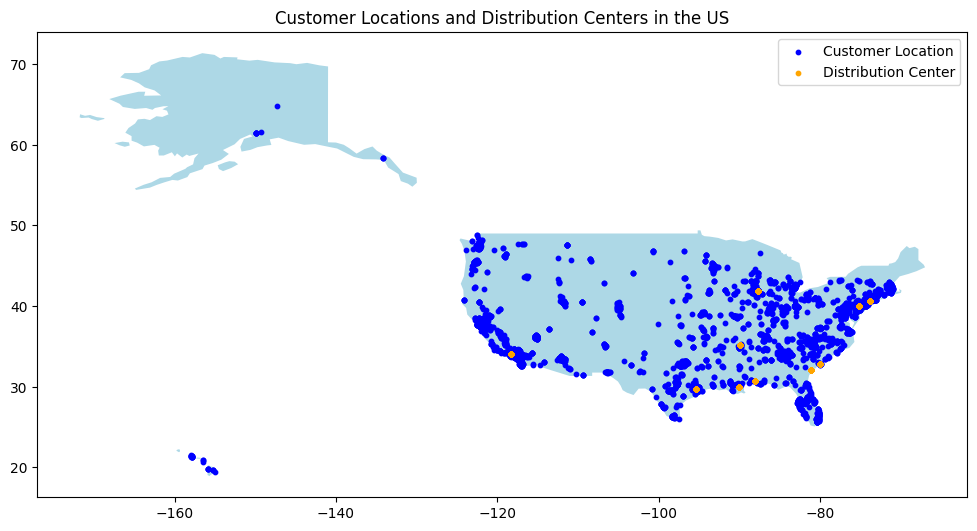

In [57]:
# Create Point geometries for customer and distribution center locations
geometry = [Point(xy) for xy in zip(domestic_df['customer_longitude'], domestic_df['customer_latitude'])]
domestic_df_gdf = GeoDataFrame(domestic_df, geometry=geometry)
dc_geometry = [Point(xy) for xy in zip(domestic_df['dc_longitude'], domestic_df['dc_latitude'])]
domestic_df_gdf_dc = GeoDataFrame(domestic_df, geometry=dc_geometry)

# Filter for US territory
us = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))[gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))['name'] == 'United States of America']

# Plot the US territory with light blue color and overlay customer points
ax = us.plot(figsize=(12, 10), facecolor='lightblue')  # Set facecolor to light blue
domestic_df_gdf.plot(ax=ax, color='blue', markersize=10, label='Customer Location')  # Add label for legend
domestic_df_gdf_dc.plot(ax=ax, color='orange', markersize=10, label='Distribution Center')  # Add label for legend

# Add legend
plt.legend()

# Adjust title and display the plot
plt.title('Customer Locations and Distribution Centers in the US')
plt.show()


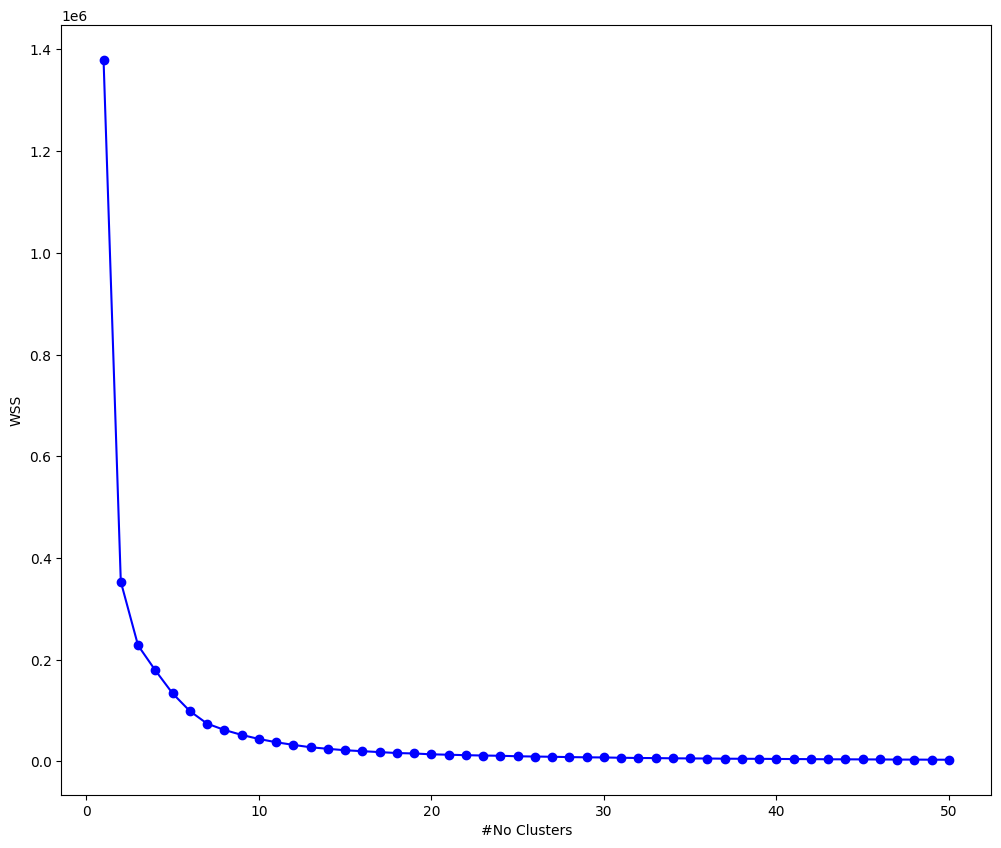

In [58]:
cluster_cols = ['customer_longitude', 'customer_latitude']
df_clus=domestic_df[cluster_cols]


warnings.filterwarnings("ignore")  # Ignore warning messages

cluster_range = range(1,51)
cluster_wss = []

for num_cluster in cluster_range:
    clusters = KMeans(num_cluster)
    clusters.fit(df_clus)
    cluster_wss.append(clusters.inertia_)

fig = plt.figure(figsize=(12, 10))
plt.xlabel('#No Clusters')
plt.ylabel('WSS')
plt.plot(cluster_range, cluster_wss, marker = 'o', color='blue')
plt.show()

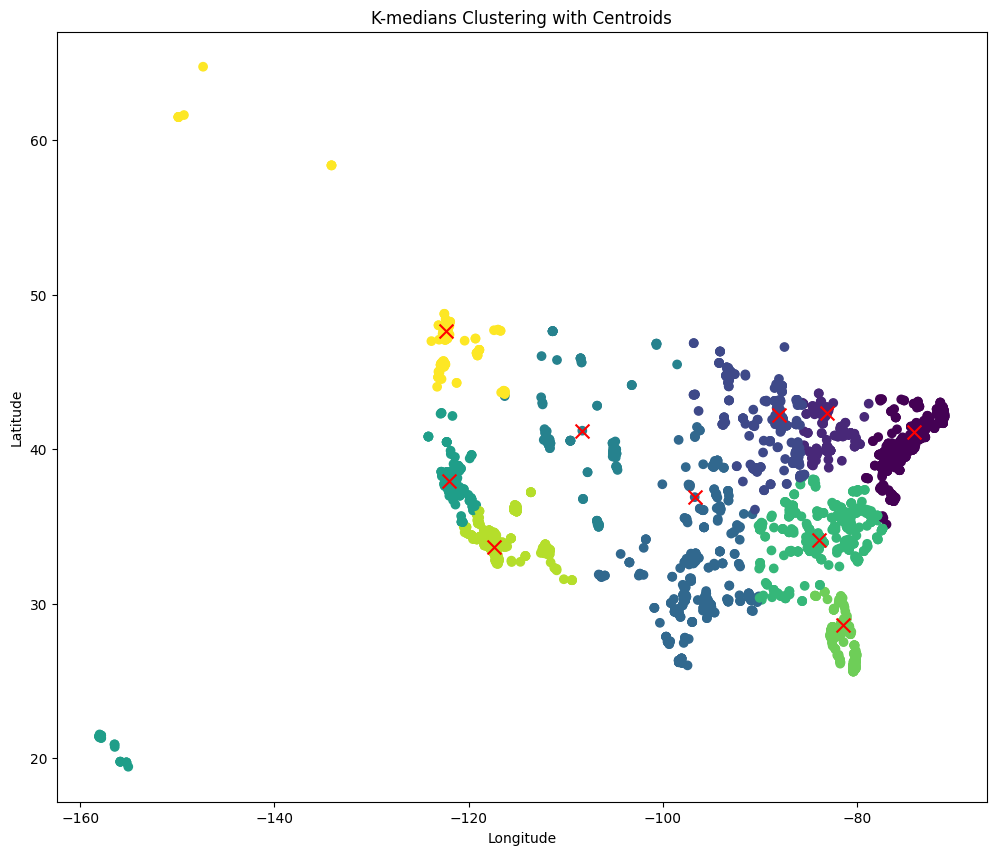

    customer_longitude  customer_latitude  cluster
0           -89.331811          43.066362        2
1          -117.318668          33.144374        8
2           -94.510106          37.019306        3
3           -82.382191          36.295325        6
4           -76.865842          39.136438        0
..                 ...                ...      ...
5          -122.022538          37.950805        5
6           -83.940889          34.088114        6
7           -81.429663          28.621742        7
8          -117.406469          33.646703        8
9          -122.291807          47.647486        9

[3946 rows x 3 columns]


In [59]:
# Define the columns for clustering
cluster_cols = ['customer_longitude', 'customer_latitude']
df_clus = domestic_df[cluster_cols]

K = 10
# Define the initial medians for K-Medians clustering
initial_medians = [[-70,45],
                   [-80,  45],
                   [-90,  45],
                   [-100,  45],
                   [-110,  45],
                   [-120,  45 ],
                   [-75,  30],
                   [-85,  30 ],
                   [-110,   30],
                   [-120,  50]]

# Create K-Medians instance with initial medians
kmedians_instance = kmedians(df_clus.values.tolist(), initial_medians)

# Run cluster analysis and obtain results
kmedians_instance.process()
cluster_instances = kmedians_instance.get_clusters()  # index of data points in each cluster
centers = np.array(kmedians_instance.get_medians())

# Initialize cluster membership array
clusters = np.zeros(len(df_clus))

# Label cluster membership for each point
for k, cluster_points in enumerate(cluster_instances):
    for point_index in cluster_points:
        clusters[point_index] = k  # label cluster membership for each point

# Create a DataFrame with cluster membership for each point
df_clus_with_clusters = df_clus.copy()
df_clus_with_clusters['cluster'] = clusters.astype(int)

# Create a DataFrame for centroids
centroids_df = pd.DataFrame({'customer_longitude': centers[:, 0], 'customer_latitude': centers[:, 1]})
centroids_df['cluster'] = np.arange(K)  # Assign cluster numbers to centroids

# Concatenate df_clus_with_clusters and centroids_df to include centroids in the DataFrame
df_clus_with_centroids = pd.concat([df_clus_with_clusters, centroids_df])

# Plot the clusters and centroids
fig = plt.figure(figsize=(12, 10))
plt.scatter(df_clus_with_centroids['customer_longitude'], df_clus_with_centroids['customer_latitude'], c=df_clus_with_centroids['cluster'])
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100)
plt.title("K-medians Clustering with Centroids")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Display df_clus_with_centroids DataFrame
print(df_clus_with_centroids)

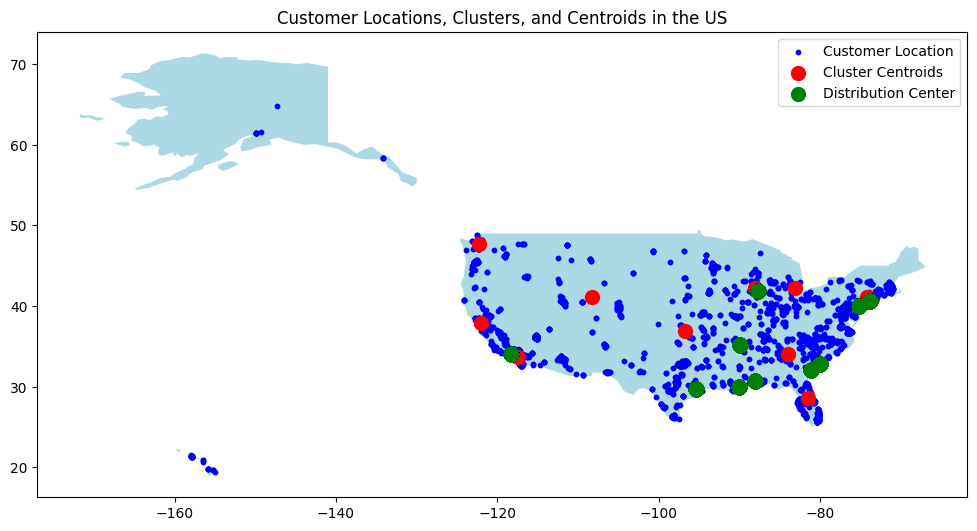

In [60]:
# Create Point geometries for customer locations
geometry_customers = [Point(xy) for xy in zip(domestic_df['customer_longitude'], domestic_df['customer_latitude'])]
domestic_df_gdf_customers = GeoDataFrame(domestic_df, geometry=geometry_customers)

# Create Point geometries for distribution centers
geometry_centers = [Point(xy) for xy in zip(centers[:, 0], centers[:, 1])]
centers_gdf = GeoDataFrame(geometry=geometry_centers)

# Filter for US territory
us = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))[gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))['name'] == 'United States of America']

# Plot the US territory with light blue color and overlay customer points, clusters, and centroids
ax = us.plot(figsize=(12, 10), facecolor='lightblue')  # Set facecolor to light blue
domestic_df_gdf_customers.plot(ax=ax, color='blue', markersize=10, label='Customer Location')  # Add label for legend
centers_gdf.plot(ax=ax, color='red', markersize=100, label='Cluster Centroids')  # Add label for legend
domestic_df_gdf_dc.plot(ax=ax, color='green', markersize=100, label='Distribution Center')  # Add label for legend

# Add legend
plt.legend()

# Adjust title and display the plot
plt.title('Customer Locations, Clusters, and Centroids in the US')
plt.show()

In [61]:
# Extract centroids' longitude, latitude, and cluster numbers
centroids_longitude = centers[:, 0]
centroids_latitude = centers[:, 1]
centroids_cluster = np.arange(K)

# Create a DataFrame for centroids with longitude, latitude, and cluster number
centroids_df = pd.DataFrame({
    'customer_longitude': centroids_longitude,
    'customer_latitude': centroids_latitude,
    'cluster': centroids_cluster
})

# Concatenate df_clus_with_clusters and centroids_df to include centroids in the DataFrame
df_clus_with_centroids = pd.concat([df_clus_with_clusters, centroids_df])

# Display df_clus_with_centroids DataFrame with centroids included
print(df_clus_with_centroids)


    customer_longitude  customer_latitude  cluster
0           -89.331811          43.066362        2
1          -117.318668          33.144374        8
2           -94.510106          37.019306        3
3           -82.382191          36.295325        6
4           -76.865842          39.136438        0
..                 ...                ...      ...
5          -122.022538          37.950805        5
6           -83.940889          34.088114        6
7           -81.429663          28.621742        7
8          -117.406469          33.646703        8
9          -122.291807          47.647486        9

[3946 rows x 3 columns]


In [62]:
# Convert centers array into a dictionary
centroids_dict = {cluster_index: (longitude, latitude) for cluster_index, (longitude, latitude) in enumerate(centers)}

# Print the centroids dictionary
print(centroids_dict)

{0: (-74.18681728, 41.08273826), 1: (-83.11412784, 42.30287408), 2: (-88.08361676999999, 42.192812535), 3: (-96.7248217, 36.88642593), 4: (-108.2974721, 41.187802695), 5: (-122.0225384, 37.95080475), 6: (-83.9408895, 34.08811401), 7: (-81.42966292, 28.6217422), 8: (-117.4064691, 33.64670253), 9: (-122.2918066, 47.64748578)}


In [63]:
# Add centroid longitude and latitude columns to the DataFrame
df_clus_with_centroids['centroid_longitude'] = df_clus_with_centroids['cluster'].map(lambda cluster: centroids_dict[cluster][0])
df_clus_with_centroids['centroid_latitude'] = df_clus_with_centroids['cluster'].map(lambda cluster: centroids_dict[cluster][1])
df_clus_with_centroids['dc_longitude'] = domestic_df ['dc_longitude']
df_clus_with_centroids['dc_latitude'] = domestic_df ['dc_latitude']

# Display the DataFrame with centroid information
df_clus_with_centroids.head()

,customer_longitude,customer_latitude,cluster,centroid_longitude,centroid_latitude,dc_longitude,dc_latitude
0,-89.331811,43.066362,2,-88.083617,42.192813,-88.0431,30.6944
1,-117.318668,33.144374,8,-117.406469,33.646703,-88.0431,30.6944
2,-94.510106,37.019306,3,-96.724822,36.886426,-88.0431,30.6944
3,-82.382191,36.295325,6,-83.940889,34.088114,-88.0431,30.6944
4,-76.865842,39.136438,0,-74.186817,41.082738,-88.0431,30.6944


In [64]:
# Function to calculate Haversine distance
def haversine_distance(lon1, lat1, lon2, lat2):
    R = 6371.0  # Earth radius in kilometers
    lon1_rad = radians(lon1)
    lat1_rad = radians(lat1)
    lon2_rad = radians(lon2)
    lat2_rad = radians(lat2)

    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

# Calculate distances and add columns to DataFrame
df_clus_with_centroids['customer_to_centroid'] = df_clus_with_centroids.apply(lambda row: haversine_distance(row['customer_longitude'], row['customer_latitude'], row['centroid_longitude'], row['centroid_latitude']), axis=1)
df_clus_with_centroids['customer_to_dc'] = df_clus_with_centroids.apply(lambda row: haversine_distance(row['customer_longitude'], row['customer_latitude'], row['dc_longitude'], row['dc_latitude']), axis=1)

# Display the updated DataFrame
df_clus_with_centroids.head()

,customer_longitude,customer_latitude,cluster,centroid_longitude,centroid_latitude,dc_longitude,dc_latitude,customer_to_centroid,customer_to_dc
0,-89.331811,43.066362,2,-88.083617,42.192813,-88.0431,30.6944,140.932384,1380.416354
1,-117.318668,33.144374,8,-117.406469,33.646703,-88.0431,30.6944,56.447987,2767.497919
2,-94.510106,37.019306,3,-96.724822,36.886426,-88.0431,30.6944,197.347306,922.095816
3,-82.382191,36.295325,6,-83.940889,34.088114,-88.0431,30.6944,283.358332,814.156506
4,-76.865842,39.136438,0,-74.186817,41.082738,-88.0431,30.6944,314.206234,1383.512766


In [65]:
from math import radians

def manhattan_distance(lon1, lat1, lon2, lat2):
    # Earth radius in kilometers
    R = 6371.0

    # Convert decimal degrees to radians
    lon1_rad = radians(lon1)
    lat1_rad = radians(lat1)
    lon2_rad = radians(lon2)
    lat2_rad = radians(lat2)

    # Calculate absolute differences
    d_lon = abs(lon2_rad - lon1_rad)
    d_lat = abs(lat2_rad - lat1_rad)

    # Calculate Manhattan distance
    distance = R * (d_lon + d_lat)

    return distance

# Calculate distances and add columns to DataFrame using Manhattan distance
df_clus_with_centroids['customer_to_centroid_manhattan'] = df_clus_with_centroids.apply(
    lambda row: manhattan_distance(row['customer_longitude'], row['customer_latitude'], row['centroid_longitude'], row['centroid_latitude']), axis=1)

df_clus_with_centroids['customer_to_dc_manhattan'] = df_clus_with_centroids.apply(
    lambda row: manhattan_distance(row['customer_longitude'], row['customer_latitude'], row['dc_longitude'], row['dc_latitude']), axis=1)

# Display the updated DataFrame
df_clus_with_centroids.head()


,customer_longitude,customer_latitude,cluster,centroid_longitude,centroid_latitude,dc_longitude,dc_latitude,customer_to_centroid,customer_to_dc,customer_to_centroid_manhattan,customer_to_dc_manhattan
0,-89.331811,43.066362,2,-88.083617,42.192813,-88.0431,30.6944,140.932384,1380.416354,235.927119,1518.997517
1,-117.318668,33.144374,8,-117.406469,33.646703,-88.0431,30.6944,56.447987,2767.497919,65.619388,3527.719349
2,-94.510106,37.019306,3,-96.724822,36.886426,-88.0431,30.6944,197.347306,922.095816,261.040742,1422.395730
3,-82.382191,36.295325,6,-83.940889,34.088114,-88.0431,30.6944,283.358332,814.156506,418.750080,1252.258856
4,-76.865842,39.136438,0,-74.186817,41.082738,-88.0431,30.6944,314.206234,1383.512766,514.312675,2181.566176


In [66]:
# euclidean distance
print('centroids distance: ', round(df_clus_with_centroids['customer_to_centroid'].sum(), 2))
print('current dc distance: ', round(df_clus_with_centroids['customer_to_dc'].sum(), 2))
print('save # km: ', round(df_clus_with_centroids['customer_to_dc'].sum(), 2) - round(df_clus_with_centroids['customer_to_centroid'].sum(), 2))
print('percentage reduce: ', round((((df_clus_with_centroids['customer_to_dc'].sum() - df_clus_with_centroids['customer_to_centroid'].sum()) / df_clus_with_centroids['customer_to_dc'].sum()) * 100), 2), '%')


centroids distance:  1194912.93
current dc distance:  7090704.85
save # km:  5895791.92
percentage reduce:  83.15 %


In [67]:
# manhattan distance
print('centroids distance: ', round(df_clus_with_centroids['customer_to_centroid_manhattan'].sum(), 2))
print('current dc distance: ', round(df_clus_with_centroids['customer_to_dc_manhattan'].sum(), 2))
print('save # km: ', round(df_clus_with_centroids['customer_to_dc_manhattan'].sum(), 2) - round(df_clus_with_centroids['customer_to_centroid_manhattan'].sum(), 2))
print('percentage reduce: ', round((((df_clus_with_centroids['customer_to_dc_manhattan'].sum() - df_clus_with_centroids['customer_to_centroid_manhattan'].sum()) / df_clus_with_centroids['customer_to_dc_manhattan'].sum()) * 100), 2), '%')


centroids distance:  1688942.69
current dc distance:  10185974.77
save # km:  8497032.08
percentage reduce:  83.42 %


https://axk51013.medium.com/%E4%B8%8D%E8%A6%81%E5%86%8D%E7%94%A8k-means-%E8%B6%85%E5%AF%A6%E7%94%A8%E5%88%86%E7%BE%A4%E6%B3%95dbscan%E8%A9%B3%E8%A7%A3-a33fa287c0e

# 3. Time-series analysis (2019-01~2024-03)

In [68]:
!pip install prophet
from prophet import Prophet  # Import Prophet library
from sklearn.metrics import mean_absolute_error
from prophet import Prophet  # Assuming you have installed the Prophet package

In [69]:
# import data
sales_trend_2019_2024_data ='https://raw.githubusercontent.com/Taweilo/theLook_ecommerce/main/Data/sales_trend_2019_2024_data.csv'
ts_df = pd.read_csv(sales_trend_2019_2024_data)
ts_df = ts_df.sort_values(['year','month'])
ts_df

,year,month,time_period,total_revenue,total_cost,gross_profit
62,2019,1,2019-1,957.43,450.43,507.00
61,2019,2,2019-2,3240.24,1551.79,1688.45
60,2019,3,2019-3,5511.08,2710.77,2800.31
59,2019,4,2019-4,6961.44,3361.76,3599.68
58,2019,5,2019-5,10263.49,4751.46,5512.03
...,...,...,...,...,...,...
4,2023,11,2023-11,344636.13,165599.26,179036.87
3,2023,12,2023-12,383973.78,183923.09,200050.69
2,2024,1,2024-1,432219.21,208032.96,224186.25
1,2024,2,2024-2,473310.36,227411.39,245898.97


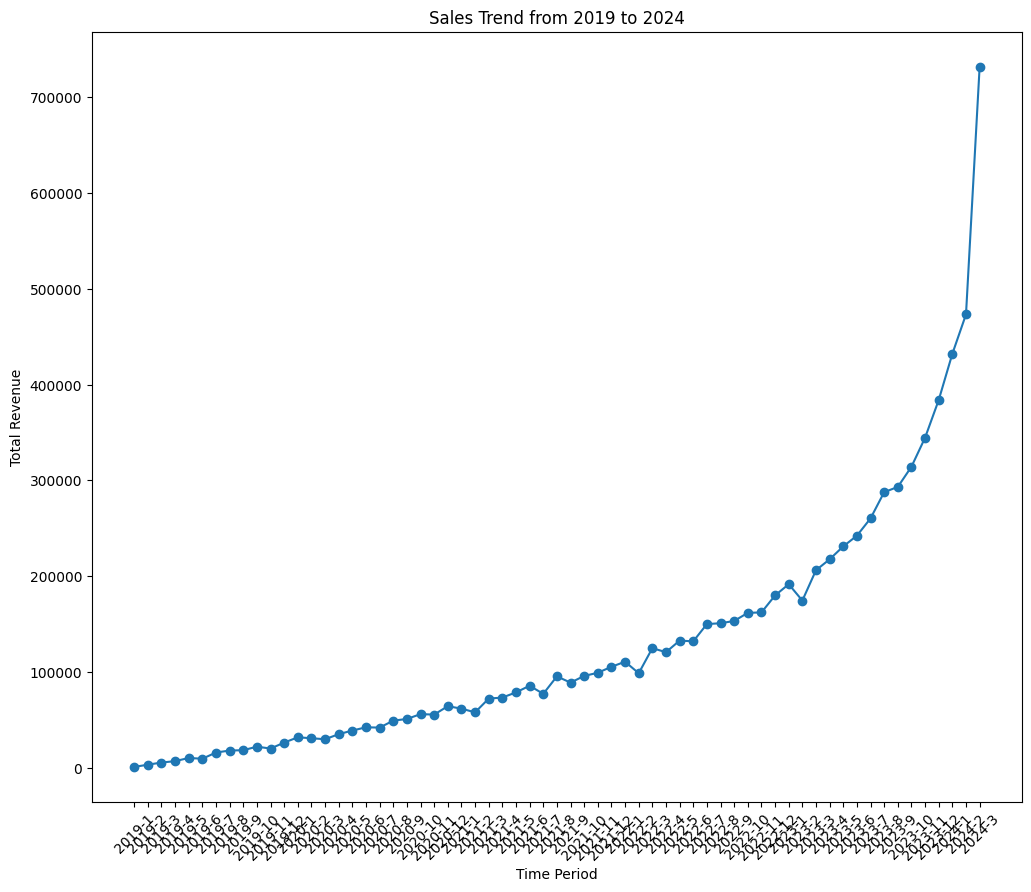

In [70]:
# Plot the trend
plt.figure(figsize=(12, 10))
plt.plot(ts_df['time_period'], ts_df['total_revenue'], marker='o')
plt.xlabel('Time Period')
plt.ylabel('Total Revenue')
plt.title('Sales Trend from 2019 to 2024')
plt.xticks(rotation=45)
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpey30ragn/4mwgokmu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpey30ragn/fktuvtsw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6270', 'data', 'file=/tmp/tmpey30ragn/4mwgokmu.json', 'init=/tmp/tmpey30ragn/fktuvtsw.json', 'output', 'file=/tmp/tmpey30ragn/prophet_model0_sm_kx4/prophet_model-20240327023407.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:34:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:34:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 50.929%


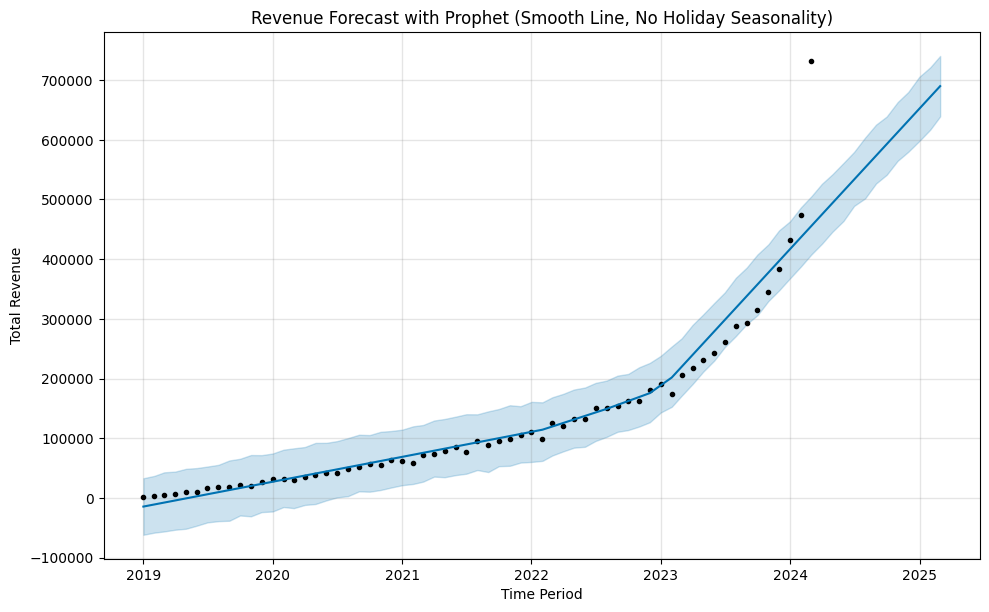

In [71]:
# Prepare the data for Prophet
prophet_df = ts_df[['time_period', 'total_revenue']]
prophet_df.columns = ['ds', 'y']  # Rename columns for Prophet

# Initialize Prophet model
model = Prophet(seasonality_mode='additive', holidays_prior_scale=0, yearly_seasonality=False)  # Set seasonality_mode and disable holiday seasonality

# Fit the model
model.fit(prophet_df)

# Make future predictions
future = model.make_future_dataframe(periods=12, freq='M')  # Predicting 12 months into the future
forecast = model.predict(future)

# Calculate Mean Absolute Error (MAE)
actual_values = prophet_df['y'].values
predicted_values = forecast['yhat'].values[:-12]  # Exclude the forecasted future values
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
print('MAPE: %.3f%%' % mape)

# Plot the forecast
fig = model.plot(forecast)
plt.xlabel('Time Period')
plt.ylabel('Total Revenue')
plt.title('Revenue Forecast with Prophet (Smooth Line, No Holiday Seasonality)')
plt.show()

https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/
